In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy==1.21.6 scikit-learn==0.24.2  pandas==1.3.5 tensorflow==2.12.0 keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 65.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import numpy as np
import pandas as pd
import os
import re
import bz2
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Visualization libraries
#import scikitplot as skplt
import plotly.graph_objects as go
from wordcloud import WordCloud

# NLTK for text processing and sentiment analysis
import nltk
nltk.download('all')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Scikit-multilearn for multi-label classification
!pip install scikit-multilearn
from skmultilearn.adapt import MLkNN

!pip install snorkel
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel, MajorityLabelVoter

# Scikit-learn for evaluation metrics and utilities
from sklearn.metrics import (
    hamming_loss, accuracy_score, precision_score, recall_score, f1_score,
    classification_report, multilabel_confusion_matrix, confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Set up your environment
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 5.6 MB/s eta 0:00:00


In [ ]:
os.chdir("/content/drive/MyDrive/Proj_dataset/archive")
files = os.listdir()
print(files)

['glove.6B.100d.txt', 'Reviews.csv', 'test.ft.txt.bz2', 'train.ft.txt.bz2', 'unlabelled data.csv', 'refined_test_data.csv', 'refined_train_data.csv']


In [ ]:
data=bz2.BZ2File("train.ft.txt.bz2")
data = bz2.BZ2File("train.ft.txt.bz2", "r")
data = data.readlines()
len(data)
data=[x.decode('utf-8') for x in data]
data[1:15]

["__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n",
 '__label__2 Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all the more if you\'ve played the game) and the hope in "A Distant Promise" and "Girl who Stole the Star" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like "Chrono Cross ~ Time\'s Scar~", "Time of the Dreamwatch", and "Chronomantique" (indefinably remeniscent of Chrono Tri

In [ ]:
labels=[0 if x.split(' ')[0]=="__label__1" else 1 for x in data][:500000]
review_original=[ x.split(' ',1)[1][:-1].lower() for x in data]
review_text=[ x.split(' ',1)[1][:-1].lower() for x in data]
data_zipped=pd.DataFrame(list(zip(labels,review_text)),columns=["Rating","Review_Text"])
data_zipped.head()

,Rating,Review_Text
0,1,stuning even for the non-gamer: this sound tra...
1,1,the best soundtrack ever to anything.: i'm rea...
2,1,amazing!: this soundtrack is my favorite music...
3,1,excellent soundtrack: i truly like this soundt...
4,1,"remember, pull your jaw off the floor after he..."


In [ ]:
data_filtered = data_zipped[data_zipped['Review_Text'].str.contains('product')]
train_data=data_filtered[~data_filtered['Review_Text'].str.contains('music|game|soundtrack|cd|song|book|album|story|film|dvd|disc|narrative|movie|track|henry|theatre|record|author|reading|writing|read|character|video|novel|travel|dishes|rap|beat|c.d.|essay|studio|watched|star|comedy|comedian|hollywood|thriller|audience|tv|series|economics|government|chapter|narrating|thomas|cast|script|stories|cinimatography|show|published|stream|reader|kindle|reading|drama|literary|adam|sandler|episodes|watch|recording|charlie brown|stars|charlie brown|show|watched|dialogue|act|voice|singer|band|microphone|bands|season|acted|artist|voice|listeners|lyrics|scene|hits|rockers|fantacy|news|plot|twist|intellectual|james brown|brown|narratione')]
len(train_data)

15536

In [ ]:
test_data=bz2.BZ2File("test.ft.txt.bz2")
test_data = bz2.BZ2File("test.ft.txt.bz2", "r")
test_data = test_data.readlines()
len(test_data)
test_data=[x.decode('utf-8') for x in test_data]
test_data[1:15]

["__label__2 One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of songs in my other video game soundtracks. I must admit that one of the songs (Life-A Distant Promise) has brought tears to my eyes on many occasions.My one complaint about this soundtrack is that they use guitar fretting effects in many of the songs, which I find distracting. But even if those weren't included I would still consider the collection worth it.\n",
 '__label__1 Batteries died within a year ...: I bought this charger in Jul 2003 and it worked OK for a while. The design is nice and convenient. However, after about

In [ ]:
labels=[0 if x.split(' ')[0]=="__label__1" else 1 for x in test_data][:500000]
review_original=[ x.split(' ',1)[1][:-1].lower() for x in test_data]
review_text=[ x.split(' ',1)[1][:-1].lower() for x in test_data]
test_data_zipped=pd.DataFrame(list(zip(labels,review_text)),columns=["Rating","Review_Text"])
test_data_zipped.head()

,Rating,Review_Text
0,1,great cd: my lovely pat has one of the great v...
1,1,one of the best game music soundtracks - for a...
2,0,batteries died within a year ...: i bought thi...
3,1,"works fine, but maha energy is better: check o..."
4,1,great for the non-audiophile: reviewed quite a...


In [ ]:
data_filtered = test_data_zipped[test_data_zipped['Review_Text'].str.contains('product')]
test_data=data_filtered[~data_filtered['Review_Text'].str.contains('music|game|soundtrack|cd|song|book|album|story|film|dvd|disc|narrative|movie|track|henry|theatre|record|author|reading|writing|read|character|video|novel|travel|dishes|rap|beat|c.d.|essay|studio|watched|star|comedy|comedian|hollywood|thriller|audience|tv|series|economics|government|chapter|narrating|thomas|cast|script|stories|cinimatography|show|published|stream|reader|kindle|reading|drama|literary|adam|sandler|episodes|watch|recording|charlie brown|stars|charlie brown|show|watched|dialogue|act|voice|singer|band|microphone|bands|season|acted|artist|voice|listeners|lyrics|scene|hits|rockers|fantacy|news|plot|twist|intellectual|james brown|brown|narratione')]
len(test_data)

15705

In [ ]:
print(files)
# Load the CSV file into a DataFrame
review_data = pd.read_csv('Reviews.csv')

# Display the first few rows to confirm it's loaded correctly
print(review_data.columns)

['glove.6B.100d.txt', 'Reviews.csv', 'test.ft.txt.bz2', 'train.ft.txt.bz2', 'unlabelled data.csv', 'refined_test_data.csv', 'refined_train_data.csv']
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [ ]:
review_data = review_data[['Score', 'Summary', 'Text']]
print(review_data.columns)
review_data = review_data.rename(columns={'Score': 'Rating', 'Text': 'Review_Text'})
review_data['Rating'] = review_data['Rating'].apply(lambda x: 1 if x in [4, 5] else 0)

print(review_data.head(5))

Index(['Score', 'Summary', 'Text'], dtype='object')
   Rating                Summary  \
0       1  Good Quality Dog Food   
1       0      Not as Advertised   
2       1  "Delight" says it all   
3       0         Cough Medicine   
4       1            Great taffy   

                                         Review_Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...  


In [ ]:
train_data = pd.concat([train_data, review_data[['Rating', 'Review_Text']].iloc[:500000]], ignore_index=True)

len(train_data)

515536

In [ ]:
aspect_keywords = {
    'usability': ['difficult', 'complicated','intuitive','useful',
 'functions',
 'wear',
 'pulled',
 'workout',
 'roll down',
 'rolled up down',
 'flexibility',
 'using',
 'useless',
 'work',
 'making',
 'function',
 'holding',
 'playing',
 'comfy',
 'fun',
 'uncomfortable',
 'taste',
 'tastes',
 'performance',
 'use',
 'moves',
 'works',
 'learning tool',
 'stacking',
 'knocking',
 'playtime',
 'spin',
 'twirl',
 'educational',
 'worked',
 'rotate',
 'used',
 'played',
 'boring',
 'portable',
 'comfortable',
 'worn',
 'play',
 'assemble',
 'drag',
 'absorbs',
 'pull',
 'wearing',
 'pushed',
 'flexible',
 'roll up',
 'wore',
 'squeezed',
 'hold',
 'feel',
 'holds',
 'bruising',
 'pushing',
 'working',
 'push',
 'put it on',
 'pulling',
 'hurts',
 'lifting',
 'put on',
 'does the job',
 'felt',
 'burned',
 'eating',
 'attention',
 'user friendly',
 'feeding',
 'warming',
 'disassemble',
 'functional',
 'effective',
 'assembly',
 'easy to put',
 'assembled',
 'operated',
 'scrubbed',
 'roll over',
 'flickering',
 'stopped',
 'stayed',
 'usage',
 'plugged',
 'stops working',
 'job',
 'functionality',
 'install',
 'uses',
 'turning',
 'feels',
 'programmed',
 'riding',
 'unstable',
 'design',
 'installation',
 'installed',
 'assembling',
 'installing',
 'designed',
 'usable',
 'User-friendly',
  'Intuitive',
'user friendly',
  'Easy to use',
  'Straightforward',
  'Simple interface',
  'Accessible',
  'Convenient',
  'Seamless experience',
  'Effortless',
  'Responsive',
  'Smooth navigation',
  'Learning curve',
  'Customizable',
  'Ergonomic',
 'Clear instructions',
  'Interactive',
  'Efficient',
 'Time-saving',
  'Functional',
'Cluttered'],
    'price': ['cost',
 'price',
 'inexpensive',
 'investment',
 'money',
 'penny',
 'pay',
 'cheap',
 'spent',
 'pricy',
 'priced',
 'expensive',
 'cheaper',
 'costs',
 'cheapest',
 'free',
 'paid',
 'dollar',
 'overpriced',
 'bucks','over priced',
 'pricing',
 'budget',
 'tax',
 'Money',
 '0',
 'expense',
 'costly',
 'fee',
'Affordable',
 'Expensive',
'Cheap',
'Budget-friendly','budget friendly',
 'Cost-effective',
'cost effective',
  'Overpriced',
'Reasonable',
 'Inexpensive',
  'Value for money',
 'Premium-priced',
'premium priced',
'Worth the price',
  'High-priced',
'high priced',
  'Economical',
'Competitive pricing',
'Fair price',
 'Low-cost','low cost',
 'Steep price',
 'Bargain',
 'Mid-range pricing',
'Exorbitant'],
    'size': ['size',
 'fits',
 'heavy',
 'sizes',
 'chart',
 'smaller',
'Compact design',
'Snug',
'Oversized',
'Mini',
'Clunky',
'Too small',
'Too large',
'perfectly',
'slim',
 'large',
 'feet',
 'big',
 'fit',
 'longer',
 'small',
 'tiny',
 'width',
 'thin',
 'taller',
 'tight',
 'small inch',
 'skinny',
 'hefty',
 'long',
 'xl',
 'length',
 'ft',
 'inches',
 'measurement',
 'streched',
 'medium',
'xlarge',
 'sized',
 'smaller size',
'Gigantic',
 'pound',
 'tall',
 'tightness',
 'bulky',
 'sizing',
 'measure',
 'shorter',
 'short',
 'tighter',
 'inch',
 'size chart',
 'xs',
 'high',
 'measured',
 'stouter',
 'wider',
 'x-large',
 'mediums',
 'bigger',
 'foot',
 'lower',
 'height',
 'lowering',
 'fitted',
 'higher',
 'lowered',
'Cumbersome',
 'larger'],
    'service': ['customer service', "support", "help", "assistance"'manual',
 'instructions',
 'contact',
 'seller',
 'shipping',
 'return',
 'arrived',
 'cardboard box',
 'box',
 'packaging',
 'packaged',
 'date',
 'contacted',
 'response',
 'refund',
 'apologized',
 'trust',
 'duplicate',
 'delivered',
 'advertisement',
 'instructional',
 'description',
 'policy',
 'unprofessional',
 'advertised',
 'pollicies',
 'replied',
 'fake',
 'company',
 'missing',
 'production',
 'consumers',
 'waiting',
 'warranty',
 'email',
 'advertising',
 'shipped',
 'misleading',
 'packed',
 'customer',
 'service',
 'replacing',
 'returns',
 'sent back',
 'advertized',
 'exchange',
 'package',
 'ship',
 'advertises',
 'comply',
 'contacting',
 'respond',
 'delivery',
 'dellivery',
 'warn',
 'described',
 'details',
 'miswire',
 'manufacturer',
 'tech staff',
 'mentioned',
 'lack',
 'faulty',
 'arrive',
 'repairable',
 'emails',
 'calls',
 'companies',
 'reply',
 'inquiries',
 'customer service',
 'receipt',
 'customers',
 'manufacture',
 'manufacturers',
 'apology',
 'receive',
 'mention',
 'condition',
 'unboxed',
 'misrepresented',
 'timely',
 'misunderstood',
 'specify',
 'packing',
 'reliable',
 'sealed',
 'refunded',
 'serviced',
 'refurbished',
 'reimbursement',
 'reported',
 'emailed',
 'shipment',
 'explained',
 'specs',
 'miss-leading','miss leading',
 'Responsive',
  'Unhelpful',
  'Friendly',
 'Rude',
 'Knowledgeable',
  'Incompetent',
' Polite',
'Prompt',
  'Slow',
'Efficient',
'Unresponsive',
'Fast',
'Delayed',
'On-time',
'Late',
'Efficient',
'Well-packaged',
' Damaged in transit',
'Safe',
 'Smooth',
 'Poor handling',
 'Excellent follow-up','excellent followup',
 'Delayed response',
'Poor after-care',
'Supportive',
'Neglectful',
'Warranty fulfillment',
'Difficult return process',
 'Great replacement service',
 'Transparent',
 'Lack of updates',
 'Frequent follow-ups',
' No contact'],
    'quality': ['high quality', 'poor quality', 'well-made', 'durable', 'cheap material','quality',
 'broken',
 'tore',
 'lasts',
 'inferior',
 'solid',
 'brass',
 'scraped',
 'smells',
 'delicate',
 'plastic',
 'stiff',
 'tolerate',
 'textured',
 'chinsy',
 'blunt',
 'sharp edges',
 'sharp',
 'waterproof',
 'soft',
 'smell',
 'smooths',
 'broke',
 'poor',
 'textureline',
 'fabric',
 'scratched',
 'metal',
 'smooth',
 'damage',
 'poorly',
 'flimsy',
 'weak',
 'blur',
 'stainless steel',
 'rubbery',
 'rubber',
 'material',
 'sturdy',
 'repair',
 'defective',
 'wrinkles',
 'smelled',
 'described',
 'last longer',
 'mark',
 'uneffected',
 'undamaged',
 'strong',
 'durable',
 'thick',
 'poorest',
 'damaged',
 'break',
 'thicker',
 'reliable',
 'low-grade',
 'tarnish',
 'breaks',
 'lasted',
 'leather',
 'conductive',
 'steady',
 'latex',
 'sleek',
 'weaker',
 'melted',
 'steel',
 'came off',
 'quallity',
 'cotton',
 'overheating',
 'lather',
 'rusted',
 'durability',
 'poor quality',
 'materials',
 'rubberized',
 'lasting',  'Flimsy',
  'Sturdy',
  'Weak',
  'Cheap',
  'Solid',
  'Fragile',
  'Heavy-duty',
 'high-quality',
  'substandard',
  'premium',
  'inferior',
  'top-notch',
  'poor-quality',
  'reliable',
  'cheap materials',
  'luxurious',
  'Wear-resistant','wear resistent',
  'Reliable',
  'Faulty',
  'Efficient',
  'Unreliable',
  'Smooth operation',
  'Problematic',
  'Consistent',
  'Malfunctioning',
  'High-performance','high performance',
  'High-quality','high quality',
  'Well-finished','well finished',
  'Low-quality performance',
  'Low-quality','low quality',
  'Rough',
  'Sleek',
  'Poor craftsmanship',
  'Polished',
  'Scratched',
  'Elegant',
  'Shoddy',
'Clean',
  'Breaks easily',
  'Wears out quickly',
  'Enduring',
  'Short lifespan',
  'Resilient',
  'Prone to damage',
  'Retains quality',
  'Fades quickly',
  'Maintains durability',
  'Works perfectly',
  'Defective',
  'Smooth functioning',
 'Prone to malfunction',
  'Glitchy',
  'Operational issues',
  'Performs as expected',
  'Faulty mechanism',
  'Seamless performance',
 'Unreliable performance'],
  }

In [ ]:
def extract_keywords(review, keywords):
    # For each keyword, check if it exists in the review and return matched keyword
    found_keywords = [keyword for keyword in keywords if re.search(rf"\b{keyword.lower()}\b", review.lower())]

    return ', '.join(found_keywords) if found_keywords else None

# Extract aspect terms and store them in respective columns
for aspect, keywords in aspect_keywords.items():
    # Apply the extraction function for each review
    train_data[aspect] = train_data['Review_Text'].apply(lambda review: extract_keywords(review, keywords))

# Display the DataFrame with extracted aspect terms
train_data.head()

,Rating,Review_Text,usability,price,size,service,quality
0,1,jobst ultrasheer thigh high: excellent product...,"difficult, wear, workout, roll down, feel",None,high,help,None
1,1,excellent product: these alphabet blocks are s...,works,None,None,None,None
2,0,great for twins: i purchased the alphabet bloc...,learning tool,price,None,None,None
3,0,not like the old formula: the formulation of t...,hold,None,None,"replied, emailed",smell
4,1,haven't found better yet...: this is the only ...,making,None,None,None,stiff


In [ ]:
def extract_keywords(review, keywords):
    # For each keyword, check if it exists in the review and return matched keyword
    found_keywords = [keyword for keyword in keywords if re.search(rf"\b{keyword.lower()}\b", review.lower())]

    return ', '.join(found_keywords) if found_keywords else None

# Extract aspect terms and store them in respective columns
for aspect, keywords in aspect_keywords.items():
    # Apply the extraction function for each review
    test_data[aspect] = test_data['Review_Text'].apply(lambda review: extract_keywords(review, keywords))

# Display the DataFrame with extracted aspect terms
test_data.head()

In [ ]:
print(train_data.columns)

Index(['Rating', 'Review_Text', 'usability', 'price', 'size', 'service',
       'quality'],
      dtype='object')


In [ ]:
print(test_data.columns)

Index(['Rating', 'Review_Text', 'usability', 'price', 'size', 'service',
       'quality'],
      dtype='object')


In [ ]:
train_data = train_data.reset_index(drop=True)

# Initialize aspects with empty strings to match the length of data_filtered
aspects = [''] * len(train_data)

for i in range(len(train_data)):
    aspect_values = []
    for col in ['usability', 'price', 'size', 'service', 'quality']:
        if pd.notna(train_data.loc[i, col]) and train_data.loc[i, col] != "NotFound":
            aspect_values.append(col)

    if aspect_values:
        aspect_values.sort()
        asp = ','.join(aspect_values)
        aspects[i] = asp  # Update the aspects list at the correct index

train_data['Aspect_Category'] = aspects
train_data.head(5)

,Rating,Review_Text,usability,price,size,service,quality,Aspect_Category,Snorkel_Sentiment_Labels
0,POSITIVE,jobst ultrasheer thigh high: excellent product...,"difficult, wear, workout, roll down, feel",None,high,help,None,"service,size,usability",positive
1,POSITIVE,excellent product: these alphabet blocks are s...,works,None,None,None,None,usability,positive
2,NEGATIVE,great for twins: i purchased the alphabet bloc...,learning tool,price,None,None,None,"price,usability",neutral
3,NEGATIVE,not like the old formula: the formulation of t...,hold,None,None,"replied, emailed",smell,"quality,service,usability",neutral
4,POSITIVE,haven't found better yet...: this is the only ...,making,None,None,None,stiff,"quality,usability",neutral


In [ ]:
test_data = test_data.reset_index(drop=True)

# Initialize aspects with empty strings to match the length of data_filtered
aspects = [''] * len(test_data)

for i in range(len(test_data)):
    aspect_values = []
    for col in ['usability', 'price', 'size', 'service', 'quality']:
        if pd.notna(test_data.loc[i, col]) and test_data.loc[i, col] != "NotFound":
            aspect_values.append(col)

    if aspect_values:
        aspect_values.sort()
        asp = ','.join(aspect_values)
        aspects[i] = asp  # Update the aspects list at the correct index

test_data['Aspect_Category'] = aspects
test_data.head(5)

,Rating,Review_Text,usability,price,size,service,quality,Aspect_Category
0,0,dont like it: this product smells when you ope...,"use, worn","money, spent, Money",None,package,smells,"price,quality,service,usability"
1,0,has no range: i suppose if you were going to s...,"work, plugged","money, Money",higher,None,"quality, Unreliable","price,quality,size,usability"
2,1,great camera: i recently purchased this camera...,"use, comfortable, hold, Easy to use","price, Affordable",None,None,quality,"price,quality,usability"
3,0,"broke the 2nd time i wore it, great until then...","difficult, wore","expensive, Expensive","size, Snug, fit",None,"broke, metal","price,quality,size,usability"
4,0,same problems as munchkin version: ditto to ot...,None,"cheap, Cheap",None,None,"flimsy, Flimsy, Cheap","price,quality"


# Use Sentiment Vader and Rating as a weak signal to learn the labels Positive, Negative, Mixed for sentiment classification

In [ ]:
sid_obj = SentimentIntensityAnalyzer()

In [ ]:
## Define constants for labelling
ABSTAIN = -1
POSITIVE = 1
NEGATIVE = 0
MIXED = 2

In [ ]:
#from snorkel.labeling import labeling_function
# Labelling function for Positive label
@labeling_function()
def lf_positive(x):
    rating=x.get(key = 'Rating')
    review=x.get(key='Review_Text')
    sentiment_dict = sid_obj.polarity_scores(review)
     # decide sentiment as positive
    if sentiment_dict['compound'] >=-0.05 and rating==1 :
        return POSITIVE
    else :
        return ABSTAIN

# Labelling function for Negative label
@labeling_function()
def lf_negative(x):
    rating=x.get(key = 'Rating')
    review=x.get(key='Review_Text')
    sentiment_dict = sid_obj.polarity_scores(review)
     # decide sentiment as negative
    if sentiment_dict['compound'] <= -0.05 and rating==0 :
        return NEGATIVE
    else :
        return ABSTAIN

# Labelling function for Mixed label
@labeling_function()
def lf_mixed(x):
    rating=x.get(key = 'Rating')
    review=x.get(key='Review_Text')
    sentiment_dict = sid_obj.polarity_scores(review)
     # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >=-0.05 and rating==0 :
        return MIXED
    elif sentiment_dict['compound'] <= -0.05 and rating==1 :
        return MIXED
    else :
        return ABSTAIN

In [ ]:

lfs = [lf_positive,lf_negative,lf_mixed]

# Apply the LFs to the tagged training data and tagged testing data
applier = PandasLFApplier(lfs)
L_train = applier.apply(train_data)
L_test = applier.apply(test_data)

# Train the label model and compute the training labels
label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train, n_epochs=1000, log_freq=50)

100%|██████████| 1000/1000 [00:01<00:00, 973.14epoch/s]


In [ ]:

lfs = [lf_positive,lf_negative,lf_mixed]

# Apply the LFs to the tagged training data and tagged testing data
applier = PandasLFApplier(lfs)
L_train = applier.apply(test_data)
L_test = applier.apply(train_data)

# Train the label model and compute the training labels
label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train, n_epochs=1000, log_freq=50)

100%|██████████| 1000/1000 [00:01<00:00, 707.50epoch/s]


In [ ]:
test_data.head(3)

,Rating,Review_Text,usability,price,size,service,quality,Aspect_Category
0,0,dont like it: this product smells when you ope...,"use, worn","money, spent, Money",None,package,smells,"price,quality,service,usability"
1,0,has no range: i suppose if you were going to s...,"work, plugged","money, Money",higher,None,"quality, Unreliable","price,quality,size,usability"
2,1,great camera: i recently purchased this camera...,"use, comfortable, hold, Easy to use","price, Affordable",None,None,quality,"price,quality,usability"


In [ ]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_positive,0,[1],0.736866,0.000004,0.000004
lf_negative,1,[0],0.078703,0.000002,0.000002
lf_mixed,2,[2],0.184437,0.000006,0.000006


In [ ]:
train_data['Snorkel_Sentiment_Labels']=label_model.predict(L=L_train, tie_break_policy="abstain")

In [ ]:
train_data['Snorkel_Sentiment_Labels'].replace(1,"positive",inplace=True)
train_data['Snorkel_Sentiment_Labels'].replace(0,"negative",inplace=True)
train_data['Snorkel_Sentiment_Labels'].replace(2,"neutral",inplace=True)

train_data['Rating'].replace(1,"POSITIVE",inplace=True)
train_data['Rating'].replace(0,"NEGATIVE",inplace=True)

In [ ]:
print("Review from Customer : ",train_data["Review_Text"][0])
print("Rating from Customer : ",train_data["Rating"][0])
print("Sentiment from SNORKEL : ",train_data["Snorkel_Sentiment_Labels"][0])

Review from Customer :  jobst ultrasheer thigh high: excellent product. however, they are very difficult to get on for older people. i feel like i've had a full day workout after getting them on. also, as the day wears on, they begin to roll down from the top and create a very deep ridge in the skin. i have to wear them, so if those two difficulties could be addressed it would be such a help.
Rating from Customer :  POSITIVE
Sentiment from SNORKEL :  positive


In [ ]:
test_data.head(3)

,Rating,Review_Text,usability,price,size,service,quality,Aspect_Category
0,0,dont like it: this product smells when you ope...,"use, worn","money, spent, Money",None,package,smells,"price,quality,service,usability"
1,0,has no range: i suppose if you were going to s...,"work, plugged","money, Money",higher,None,"quality, Unreliable","price,quality,size,usability"
2,1,great camera: i recently purchased this camera...,"use, comfortable, hold, Easy to use","price, Affordable",None,None,quality,"price,quality,usability"


In [ ]:
# Count the occurrences of each label
label_counts = train_data['Snorkel_Sentiment_Labels'].value_counts()

# Print the counts for positive, negative, and neutral
print("Positive:", label_counts.get(1, 0))  # Assuming 1 represents positive
print("Negative:", label_counts.get(-1, 0))  # Assuming -1 represents negative
print("Neutral:", label_counts.get(0, 0))  # Assuming 0 represents neutral

Positive: 95083
Negative: 40574
Neutral: 379879


In [ ]:
import pandas as pd

# Assuming new_senti_train_data is your DataFrame
positive_data = train_data[train_data['Snorkel_Sentiment_Labels'] == 'positive']
negative_data = train_data[train_data['Snorkel_Sentiment_Labels'] == 'negative']
neutral_data = train_data[train_data['Snorkel_Sentiment_Labels'] == 'neutral']

# Calculate the number of rows in each category
# Sample 15,000 rows from the positive data
positive_sample = positive_data.sample(n=40000, random_state=42)
negative_sample = negative_data.sample(n=40000, random_state=42)
neutral_sample = neutral_data.sample(n=40000, random_state=42)

# Concatenate the positive, negative, and neutral samples into a single DataFrame
filtered_data = pd.concat([positive_sample, negative_sample, neutral_sample], ignore_index=True)

# Display the filtered and concatenated dataset
print(filtered_data.shape[0])
filtered_data.head(3)

120000


,Rating,Review_Text,usability,price,size,service,quality,Aspect_Category,Snorkel_Sentiment_Labels
0,POSITIVE,After trying this new roast at the store and l...,taste,"expensive, free, Expensive",high,None,None,"price,size,usability",positive
1,POSITIVE,"Peach Mango Kool Aid, when added to water, has...",None,None,"medium, sized",None,None,size,positive
2,POSITIVE,Ingredients are all human grade - and the heal...,None,"price, cheap, Cheap",big,box,Cheap,"price,quality,service,size",positive


In [ ]:
 test_data.head(3)

,Rating,Review_Text,usability,price,size,service,quality,Aspect_Category
0,0,dont like it: this product smells when you ope...,"use, worn","money, spent, Money",None,package,smells,"price,quality,service,usability"
1,0,has no range: i suppose if you were going to s...,"work, plugged","money, Money",higher,None,"quality, Unreliable","price,quality,size,usability"
2,1,great camera: i recently purchased this camera...,"use, comfortable, hold, Easy to use","price, Affordable",None,None,quality,"price,quality,usability"


In [ ]:
("/content/drive/MyDrive/Proj_dataset/archive")
import pandas as pd

# Define the path where the CSV file will be saved
output_path = "/content/drive/MyDrive/Proj_dataset/filtered_data.csv"

# Save the DataFrame to CSV
filtered_data.to_csv(output_path, index=False)

print(f"Data saved successfully to {output_path}")


NameError: name 'filtered_data' is not defined

In [ ]:
os.chdir("/content/drive/MyDrive/Proj_dataset")
file = os.listdir()
print(file)

['base_paper1.pdf', 'archive', 'results', 'new_senti_train_data.csv', 'amazon_tagged_data.csv', 'test_data.csv', 'gradio_app.html', 'web_app_demo.ipynb', 'bilstm_model.h5', 'bilstm_sentiment_model.h5', 'filtered_data.csv']


In [ ]:
filtered_data = "/content/drive/MyDrive/Proj_dataset/filtered_data.csv"
test_data = "/content/drive/MyDrive/Proj_dataset/test_data.csv"
# Load the CSV file into a DataFrame
filtered_data = pd.read_csv(filtered_data)
test_data = pd.read_csv(test_data)

In [ ]:
filtered_data['Aspect_Terms'] = filtered_data[['price', 'quality', 'size', 'usability', 'service']].apply(
    lambda row: ', '.join(filter(pd.notna, row)), axis=1
)
filtered_data.head(3)

,Rating,Review_Text,usability,price,size,service,quality,Aspect_Category,Snorkel_Sentiment_Labels,Aspect_Terms
0,1,After trying this new roast at the store and l...,taste,"expensive, free, Expensive",high,NaN,NaN,"price,size,usability",positive,"expensive, free, Expensive, high, taste"
1,1,"Peach Mango Kool Aid, when added to water, has...",NaN,NaN,"medium, sized",NaN,NaN,size,positive,"medium, sized"
2,1,Ingredients are all human grade - and the heal...,NaN,"price, cheap, Cheap",big,box,Cheap,"price,quality,service,size",positive,"price, cheap, Cheap, Cheap, big, box"


In [ ]:
filtered_data.head(3)

,Rating,Review_Text,usability,price,size,service,quality,Aspect_Category,Snorkel_Sentiment_Labels,Aspect_Terms
0,1,After trying this new roast at the store and l...,taste,"expensive, free, Expensive",high,NaN,NaN,"price,size,usability",positive,"expensive, free, Expensive, high, taste"
1,1,"Peach Mango Kool Aid, when added to water, has...",NaN,NaN,"medium, sized",NaN,NaN,size,positive,"medium, sized"
2,1,Ingredients are all human grade - and the heal...,NaN,"price, cheap, Cheap",big,box,Cheap,"price,quality,service,size",positive,"price, cheap, Cheap, Cheap, big, box"


In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from transformers import pipeline

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('sentiwordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Constants for Sentiment Labels in lowercase
POSITIVE = 'positive'
NEGATIVE = 'negative'
NEUTRAL = 'neutral'

# Initialize VADER and BERT sentiment analyzer
sia = SentimentIntensityAnalyzer()
sentiment_analyzer = pipeline("sentiment-analysis")


# Function to get WordNet POS tag for SentiWordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    return None

# SentiWordNet-based Sentiment Scoring
def get_sentiwordnet_score(word, pos_tag):
    synsets = list(swn.senti_synsets(word, pos_tag))
    if not synsets:
        return 0  # Neutral if no matching synset
    pos_score = sum([syn.pos_score() for syn in synsets]) / len(synsets)
    neg_score = sum([syn.neg_score() for syn in synsets]) / len(synsets)
    return pos_score - neg_score  # Positive - Negative score

from transformers import pipeline, AutoTokenizer

# Load the tokenizer used by the sentiment-analyzer model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Updated BERT sentiment analyzer call
def combined_aspect_review_sentiment(x):
    review = x.get('Review_Text', '')
    rating = x.get('Rating', '') # Use lowercase for consistency

    # Ensure `review` is not empty
    if not review:
        return NEUTRAL  # Return neutral sentiment for empty reviews

    # Truncate review to max length for the BERT model
    max_length = 1012
    tokens = tokenizer.tokenize(review, truncation=True, max_length=512)
    truncated_review = tokenizer.convert_tokens_to_string(tokens)

    # Initialize list for aspect-specific scores
    aspect_scores = []

    # Check each aspect and match with keywords
    for aspect, keywords in aspect_keywords.items():
        if pd.isna(x.get(aspect)):
            continue

        # Tokenize and POS-tag the review
        tokens = word_tokenize(truncated_review)
        tagged_tokens = pos_tag(tokens)

        # Check for presence of aspect keywords and get SentiWordNet scores
        for keyword in keywords:
            if keyword.lower() in truncated_review.lower():
                for word, tag in tagged_tokens:
                    if keyword.lower() in word.lower():
                        wn_tag = get_wordnet_pos(tag)
                        if wn_tag:
                            score = get_sentiwordnet_score(word, wn_tag)
                            aspect_scores.append(score)

    # Calculate average SentiWordNet score if any aspect terms matched
    avg_sentiwordnet_score = np.mean(aspect_scores) if aspect_scores else 0

    # VADER sentiment score for review
    vader_score = sia.polarity_scores(truncated_review)['compound']

    # BERT sentiment score
    # Ensure the input is properly truncated and padded during BERT processing
    bert_result = sentiment_analyzer(truncated_review[:max_length])[0]
    bert_score = 1 if bert_result['label'] == 'POSITIVE' else -1

    # Combined sentiment score
    combined_score = (avg_sentiwordnet_score * 0.4) + (vader_score * 0.35) + (bert_score * 0.25)

    # Ensemble-based decision-making
    if combined_score > 0.25 or (vader_score > 0.5 and bert_score == 1):
        return POSITIVE
    elif combined_score < -0.25 or (vader_score < -0.5 and bert_score == -1):
        return NEGATIVE
    else:
        return NEUTRAL  # Default to NEUTRAL if no conditions are met

# Apply Labeling to Dataset
def apply_labeling(data):
    data['sentiment_label'] = data.apply(combined_aspect_review_sentiment, axis=1)
    return data

# Example usage with new_senti_train_data DataFrame
# Ensure new_senti_train_data contains columns ['Review_Text', 'Rating', 'price', 'quality', 'size', 'service', 'usability']
filtered_data = apply_labeling(filtered_data)


# Display the DataFrame with the new sentiment labels
print(filtered_data.head(3))



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0
You seem to 

   Rating                                        Review_Text usability  \
0       1  After trying this new roast at the store and l...     taste   
1       1  Peach Mango Kool Aid, when added to water, has...       NaN   
2       1  Ingredients are all human grade - and the heal...       NaN   

                        price           size service quality  \
0  expensive, free, Expensive           high     NaN     NaN   
1                         NaN  medium, sized     NaN     NaN   
2         price, cheap, Cheap            big     box   Cheap   

              Aspect_Category Snorkel_Sentiment_Labels  \
0        price,size,usability                 positive   
1                        size                 positive   
2  price,quality,service,size                 positive   

                              Aspect_Terms sentiment_label  
0  expensive, free, Expensive, high, taste        positive  
1                            medium, sized        positive  
2     price, cheap, Cheap, Che

In [ ]:
print('unique value of newalgo:',filtered_data['sentiment_label'].unique())
filtered_data['Snorkel_Sentiment_Labels'].unique()
print('unique of snorkel:',filtered_data['Snorkel_Sentiment_Labels'].unique())

unique value of newalgo: ['positive' 'neutral' 'negative']
unique of snorkel: ['positive' 'negative' 'neutral']


In [ ]:
train_data.head(3)

EVALUATE ALGORITHM AND SNORKEL LABEL

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calculate and print the number of differences
num_differences = (filtered_data['sentiment_label'] != filtered_data['Snorkel_Sentiment_Labels']).sum()
print("Number of differences:", num_differences)

# Extract the true and predicted labels
y_true = filtered_data['sentiment_label']
y_pred = filtered_data['Snorkel_Sentiment_Labels']

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Cohen's Kappa
#kappa = cohen_kappa_score(train_data['sentiment_label'], train_data['Snorkel_Sentiment_Labels'])
#print(f"Cohen's Kappa: {kappa}")
# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Number of differences: 27111
Accuracy: 0.77
Precision: 0.78
Recall: 0.77
F1 Score: 0.77

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.87      0.84     37765
     neutral       0.66      0.67      0.67     39298
    positive       0.84      0.79      0.81     42937

    accuracy                           0.77    120000
   macro avg       0.77      0.77      0.77    120000
weighted avg       0.78      0.77      0.77    120000



BiLSTM MODEL

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Constants
max_review_length = 100  # Maximum length of review text
vocab_size = 5000        # Vocabulary size for embedding layer
embedding_dim = 100      # Dimension of embedding layer
aspect_lexicon_size = 10 # Number of features for aspect terms (max sequence length for aspect terms)
hidden_units = 64        # Number of hidden units in BiLSTM layer

# Assuming filtered_data is your DataFrame containing the necessary columns
reviews = filtered_data['Review_Text']
aspect_terms = filtered_data['Aspect_Terms']
ratings = filtered_data['Rating']
labels = filtered_data['Snorkel_Sentiment_Labels']

# Step 1: Convert alphabetic ratings to numeric values
rating_encoder = LabelEncoder()
ratings_numeric = rating_encoder.fit_transform(ratings)  # This will map ratings like 'positive' to integers (0, 1, 2)

# Step 2: One-hot encode the numeric ratings
y_ratings = tf.keras.utils.to_categorical(ratings_numeric, num_classes=3)  # Assuming 3 classes: positive, negative, neutral

# Step 3: Tokenize the 'Review_Text' column
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(reviews)
X_reviews = tokenizer.texts_to_sequences(reviews)
X_reviews = pad_sequences(X_reviews, maxlen=max_review_length)

# Step 4: Preprocess the 'Aspect_Terms' column
# Replace missing values in Aspect_Terms with an empty string
filtered_data['Aspect_Terms'] = filtered_data['Aspect_Terms'].fillna('')
aspect_terms = filtered_data['Aspect_Terms'].values

# Initialize a tokenizer for aspect terms and fit it on the Aspect_Terms data
tokenizer_aspects = Tokenizer(num_words=vocab_size)  # Set vocab_size as needed
tokenizer_aspects.fit_on_texts(aspect_terms)

# Convert aspect terms to sequences of integer indices
X_aspects = tokenizer_aspects.texts_to_sequences(aspect_terms)

# Optionally, pad the sequences if necessary
X_aspects = pad_sequences(X_aspects, maxlen=aspect_lexicon_size)

# Step 5: Encode the sentiment labels
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(labels)
y_labels = tf.keras.utils.to_categorical(y_labels, num_classes=3)  # Assuming 3 classes: positive, neutral, negative

# Step 6: Define Inputs for the BiLSTM Model
review_text_input = Input(shape=(max_review_length,), dtype='int32', name="review_text")
aspect_lexicon_input = Input(shape=(aspect_lexicon_size,), name="aspect_lexicon")
rating_input = Input(shape=(1,), name="rating")

# Step 7: Define the embedding and BiLSTM layers
# Embedding layer for review text
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_review_length)(review_text_input)

# BiLSTM layer for processing the review text
lstm_out = Bidirectional(LSTM(units=hidden_units, return_sequences=False))(embedding)

# Concatenate BiLSTM output with aspect lexicon and rating inputs
concatenated = Concatenate()([lstm_out, aspect_lexicon_input, rating_input])

# Step 8: Define the output layer for sentiment classification
dense_output = Dense(units=3, activation='softmax')(concatenated)  # 3 classes for sentiment (positive, neutral, negative)

# Define the model
model = Model(inputs=[review_text_input, aspect_lexicon_input, rating_input], outputs=dense_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Step 9: Set up EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 10: Train the model with early stopping and validation split
model.fit([X_reviews, X_aspects, ratings_numeric], y_labels, epochs=9, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
#model.fit([X_reviews, X_aspects, ratings_numeric], y_labels, epochs=10, batch_size=32, validation_split=0.2)

model.save("bilstm_sentiment_model.h5")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ review_text (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 100)       │        500,000 │ review_text[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │         84,480 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ aspect_lexicon            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 139)            │              0 │ bidirectional[0][0],   │
│                           │                        │                │ aspect_lexicon[0][0],  │
│                           │                        │                │ rating[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3)              │            420 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 584,900 (2.23 MB)

 Trainable params: 584,900 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.7194 - loss: 1.6595 - val_accuracy: 0.3981 - val_loss: 1.2553
Epoch 2/9
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.8899 - loss: 0.2927 - val_accuracy: 0.5400 - val_loss: 1.0661
Epoch 3/9
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9230 - loss: 0.2069 - val_accuracy: 0.6595 - val_loss: 0.7883
Epoch 4/9
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.9455 - loss: 0.1520 - val_accuracy: 0.7363 - val_loss: 0.6562
Epoch 5/9
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 72s 11ms/step - accuracy: 0.9607 - loss: 0.1123 - val_accuracy: 0.6742 - val_loss: 1.0068
Epoch 6/9
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9725 - loss: 0.0849 - val_accuracy: 0.7142 - val_loss: 0.9346
Epoch 7/9
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9814 - loss: 0.0611 - val_accuracy: 0.7602 - val_loss: 0.8035


In [ ]:
# Load the saved model
from tensorflow.keras.models import load_model

model = load_model("bilstm_sentiment_model.h5")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define constants (adjust these as per your model's setup)
MAX_REVIEW_LENGTH = 100  # Max length for review text sequences
ASPECT_LEXICON_SIZE = 10  # Max length for aspect terms sequences
NUM_WORDS = 5000  # Number of words for Tokenizer vocabulary

# Initialize Tokenizers for reviews and aspects
tokenizer_reviews = Tokenizer(num_words=NUM_WORDS)
tokenizer_aspects = Tokenizer(num_words=NUM_WORDS)

# Load the saved model
model = load_model("bilstm_sentiment_model.h5")

# Encode sentiment labels
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(["Negative", "Neutral", "Positive"])  # Update if necessary

# Define a demo input
demo_review = ["Great value for money. The usability is okay, and the price is high"]
demo_aspect_terms = ["high, usability, price,great, okay"]
demo_rating = [1]  # Binary rating: 1 for positive, 0 for neutral/negative

# Tokenize and pad the demo review
demo_review_seq = tokenizer_reviews.texts_to_sequences(demo_review)
demo_review_padded = pad_sequences(demo_review_seq, maxlen=MAX_REVIEW_LENGTH)

# Tokenize and pad the aspect terms
demo_aspect_seq = tokenizer_aspects.texts_to_sequences(demo_aspect_terms)
demo_aspect_padded = pad_sequences(demo_aspect_seq, maxlen=ASPECT_LEXICON_SIZE)

# Convert demo rating to a numpy array
demo_rating_array = np.array(demo_rating).reshape(-1, 1)  # Ensure correct shape

# Predict sentiment using the model
predictions = model.predict([demo_review_padded, demo_aspect_padded, demo_rating_array])

# Decode predictions
predicted_class = np.argmax(predictions, axis=1)
sentiment_labels = label_encoder.inverse_transform(predicted_class)

# Display the results
print("Predicted Sentiment Scores:", predictions)
print("Predicted Sentiment Label:", sentiment_labels[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Predicted Sentiment Scores: [[2.9744048e-04 4.2834885e-02 9.5686764e-01]]
Predicted Sentiment Label: Positive


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define constants (adjust these as per your model's setup)
MAX_REVIEW_LENGTH = 100  # Max length for review text sequences
ASPECT_LEXICON_SIZE = 10  # Max length for aspect terms sequences
NUM_WORDS = 5000  # Number of words for Tokenizer vocabulary

# Initialize Tokenizers for reviews and aspects
tokenizer_reviews = Tokenizer(num_words=NUM_WORDS)
tokenizer_aspects = Tokenizer(num_words=NUM_WORDS)

# Load the saved model
model = load_model("bilstm_sentiment_model.h5")

# Encode sentiment labels
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(["Negative", "Neutral", "Positive"])  # Update if necessary

# Define a demo input
demo_review = ["The product quality is bad, it does not work as expected. But service is good and okay with its usability.fair price with excellent durable "]
demo_aspect_terms = ["bad, not,good,okay, fair , price , excellent"]
demo_rating = [0]  # Binary rating: 1 for positive, 0 for neutral/negative

# Tokenize and pad the demo review
demo_review_seq = tokenizer_reviews.texts_to_sequences(demo_review)
demo_review_padded = pad_sequences(demo_review_seq, maxlen=MAX_REVIEW_LENGTH)

# Tokenize and pad the aspect terms
demo_aspect_seq = tokenizer_aspects.texts_to_sequences(demo_aspect_terms)
demo_aspect_padded = pad_sequences(demo_aspect_seq, maxlen=ASPECT_LEXICON_SIZE)

# Convert demo rating to a numpy array
demo_rating_array = np.array(demo_rating).reshape(-1, 1)  # Ensure correct shape

# Predict sentiment using the model
predictions = model.predict([demo_review_padded, demo_aspect_padded, demo_rating_array])

# Decode predictions
predicted_class = np.argmax(predictions, axis=1)
sentiment_labels = label_encoder.inverse_transform(predicted_class)

# Display the results
print("Predicted Sentiment Scores:", predictions)
print("Predicted Sentiment Label:", sentiment_labels[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted Sentiment Scores: [[0.310039   0.66617364 0.02378737]]
Predicted Sentiment Label: Neutral


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, hamming_loss, accuracy_score
import numpy as np

# Predict on the validation data (or test data)
# Ensure you split data before calling `model.fit` or use unseen test data
y_pred_prob = model.predict([X_reviews, X_aspects, ratings_numeric])
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_labels, axis=1)  # True class labels

# Compute macro and micro metrics
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')

# Compute Hamming Loss
hamming = hamming_loss(y_true, y_pred)

# Display results
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Micro Precision: {micro_precision:.4f}")
print(f"Micro Recall: {micro_recall:.4f}")
print(f"Micro F1-Score: {micro_f1:.4f}")
print(f"Hamming Loss: {hamming:.4f}")


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 144s 38ms/step
Macro Precision: 0.9358
Macro Recall: 0.9341
Macro F1-Score: 0.9330
Micro Precision: 0.9342
Micro Recall: 0.9342
Micro F1-Score: 0.9342
Hamming Loss: 0.0659


In [ ]:
filtered_data.head(3)

,Rating,Review_Text,usability,price,size,service,quality,Aspect_Category,Snorkel_Sentiment_Labels,Aspect_Terms
0,POSITIVE,After trying this new roast at the store and l...,taste,"expensive, free, Expensive",high,NaN,NaN,"price,size,usability",positive,"expensive, free, Expensive, high, taste"
1,POSITIVE,"Peach Mango Kool Aid, when added to water, has...",NaN,NaN,"medium, sized",NaN,NaN,size,positive,"medium, sized"
2,POSITIVE,Ingredients are all human grade - and the heal...,NaN,"price, cheap, Cheap",big,box,Cheap,"price,quality,service,size",positive,"price, cheap, Cheap, Cheap, big, box"


In [ ]:
test_data.head(3)

,Rating,Review_Text,usability,price,size,service,quality,Aspect_Category
0,0,dont like it: this product smells when you ope...,"use, worn","money, spent, Money",NaN,package,smells,"price,quality,service,usability"
1,0,has no range: i suppose if you were going to s...,"work, plugged","money, Money",higher,NaN,"quality, Unreliable","price,quality,size,usability"
2,1,great camera: i recently purchased this camera...,"use, comfortable, hold, Easy to use","price, Affordable",NaN,NaN,quality,"price,quality,usability"


BERT BASED MODEL

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Lambda, Embedding, Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder

# Constants
max_review_length = 128
absa_model_name = "microsoft/deberta-v3-base"

# Load Tokenizer and ABSA-BERT model
tokenizer = AutoTokenizer.from_pretrained(absa_model_name)
absa_model = TFAutoModel.from_pretrained(absa_model_name)

# Dataset columns (assuming `filtered_data` is a pandas DataFrame)
reviews = filtered_data['Review_Text'].astype(str)
aspect_terms = filtered_data['Aspect_Terms'].astype(str)
aspect_category = filtered_data['Aspect_Category']
ratings = filtered_data['Rating'].astype(float)  # Ensure ratings are float
debug_labels = filtered_data['Snorkel_Sentiment_Labels'].astype(str)

# Step 1: Tokenize `Review_Text` with `Aspect_Terms`
combined_texts = reviews + " [SEP] " + aspect_terms
encoded_inputs = tokenizer(
    list(combined_texts),
    max_length=max_review_length,
    padding="max_length",
    truncation=True,
    return_tensors="tf"
)

# Step 2: Encode `Aspect_Category`
label_encoder_category = LabelEncoder()
aspect_category_encoded = label_encoder_category.fit_transform(aspect_category)

# Embed aspect category for input to the model
unique_categories = len(label_encoder_category.classes_)
aspect_category_input = Input(shape=(1,), dtype=tf.int32, name="aspect_category_input")
aspect_category_emb = Embedding(input_dim=unique_categories, output_dim=16)(aspect_category_input)
aspect_category_emb = Flatten()(aspect_category_emb)

# Step 3: Encode Labels (`Snorkel_Sentiment_Labels`)
label_encoder_sentiment = LabelEncoder()
y_labels = label_encoder_sentiment.fit_transform(debug_labels)
y_labels = tf.keras.utils.to_categorical(y_labels, num_classes=3)

# Step 4: Process `Ratings`
ratings_input = Input(shape=(1,), dtype=tf.float32, name="ratings_input")
ratings_dense = Dense(16, activation="relu")(ratings_input)

# Inputs for the Model
bert_input_ids = Input(shape=(max_review_length,), dtype=tf.int32, name="input_ids")
bert_attention_mask = Input(shape=(max_review_length,), dtype=tf.int32, name="attention_mask")

# ABSA-BERT Embeddings
def extract_bert_embeddings(inputs):
    input_ids, attention_mask = inputs
    bert_output = absa_model(input_ids=input_ids, attention_mask=attention_mask)["last_hidden_state"]
    pooled_output = tf.reduce_mean(bert_output, axis=1)  # Mean pooling
    return pooled_output

bert_embeddings = Lambda(
    extract_bert_embeddings,
    output_shape=(absa_model.config.hidden_size,)  # DeBERTa's hidden size
)([bert_input_ids, bert_attention_mask])

# Concatenate Features
concatenated = Concatenate()([bert_embeddings, aspect_category_emb, ratings_dense])

# Add Dropout
dropout = Dropout(0.2)(concatenated)

# Classification Head
dense_output = Dense(64, activation="relu")(dropout)
final_output = Dense(3, activation="softmax", name="sentiment_output")(dense_output)

# Define Model
model = Model(
    inputs=[bert_input_ids, bert_attention_mask, aspect_category_input, ratings_input],
    outputs=final_output
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Prepare inputs for training
input_data = [
    encoded_inputs["input_ids"].numpy(),
    encoded_inputs["attention_mask"].numpy(),
    aspect_category_encoded.reshape(-1, 1),
    ratings.to_numpy().reshape(-1, 1)
]

# Train the Model
history = model.fit(
    input_data,
    y_labels,
    epochs=5,
    batch_size=16,
    validation_split=0.1
)

# Model Summary
model.summary()

All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Epoch 1/5
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 1037s 149ms/step - accuracy: 0.4773 - loss: 1.0664 - val_accuracy: 0.1276 - val_loss: 1.2373
Epoch 2/5
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 979s 142ms/step - accuracy: 0.7346 - loss: 0.6378 - val_accuracy: 0.2424 - val_loss: 1.1437
Epoch 3/5
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 983s 142ms/step - accuracy: 0.7524 - loss: 0.5503 - val_accuracy: 0.3042 - val_loss: 1.0907
Epoch 4/5
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 1006s 149ms/step - accuracy: 0.7610 - loss: 0.5287 - val_accuracy: 0.3089 - val_loss: 1.1125
Epoch 5/5
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 1048s 150ms/step - accuracy: 0.7603 - loss: 0.5268 - val_accuracy: 0.2399 - val_loss: 1.1335


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ aspect_category_input     │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 16)          │            512 │ aspect_category_input… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ratings_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 768)            │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16)             │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │             32 │ ratings_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 800)            │              0 │ lambda[0][0],          │
│                           │                        │                │ flatten[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 800)            │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │         51,264 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_output (Dense)  │ (None, 3)              │            195 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 156,011 (609.42 KB)

 Trainable params: 52,003 (203.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 104,008 (406.29 KB)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
import numpy as np

# Assuming `y_true` contains the true labels and `y_pred` contains model predictions.
# Get the predicted labels
predictions = model.predict(input_data)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
y_true = np.argmax(y_labels, axis=1)  # True labels from one-hot encoding to indices

# Calculate macro metrics
macro_f1 = f1_score(y_true, y_pred, average='macro')
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')

# Calculate micro metrics
micro_f1 = f1_score(y_true, y_pred, average='micro')
micro_precision = precision_score(y_true, y_pred, average='micro')
micro_recall = recall_score(y_true, y_pred, average='micro')

# Calculate Hamming loss
hamming = hamming_loss(y_true, y_pred)

# Display metrics
print("Macro F1-score:", macro_f1)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Micro F1-score:", micro_f1)
print("Micro Precision:", micro_precision)
print("Micro Recall:", micro_recall)
print("Hamming Loss:", hamming)


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 950s 249ms/step
Macro F1-score: 0.6773155189892348
Macro Precision: 0.745952806875929
Macro Recall: 0.7242666666666667
Micro F1-score: 0.7242666666666666
Micro Precision: 0.7242666666666666
Micro Recall: 0.7242666666666666
Hamming Loss: 0.27573333333333333


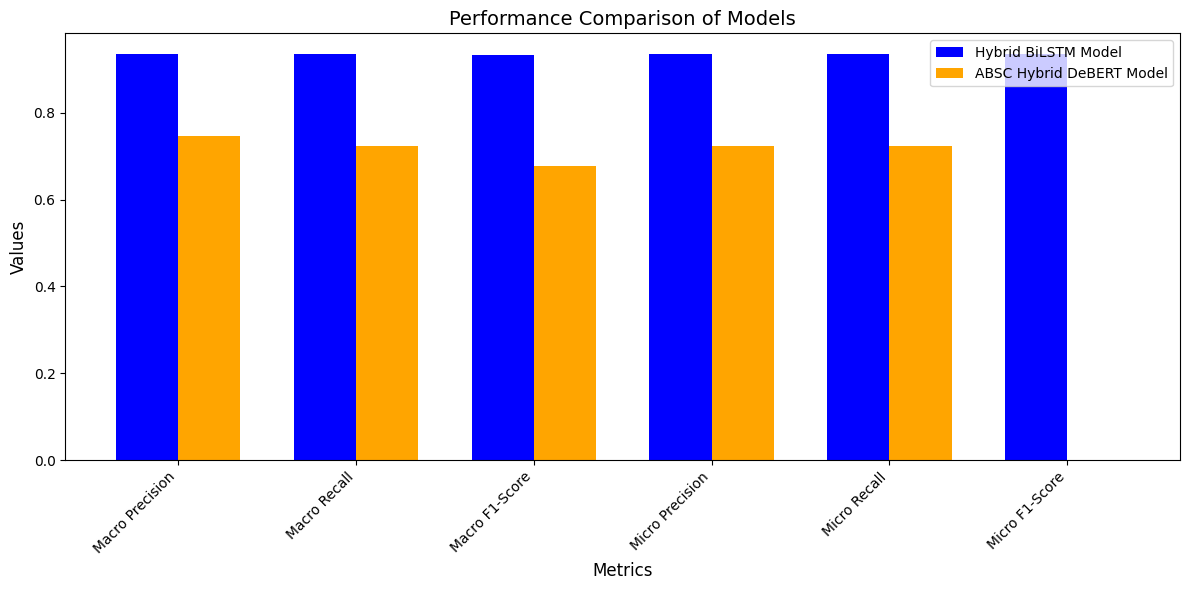

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Hybrid BiLSTM Model
bilstm_metrics = {
    "Macro Precision": 0.9358,
    "Macro Recall": 0.9341,
    "Macro F1-Score": 0.9330,
    "Micro Precision": 0.9342,
    "Micro Recall": 0.9342,
    "Micro F1-Score": 0.9342,

}

# Data for ABSC Hybrid DeBERT Model
debert_metrics = {
    "Macro F1-Score": 0.6773,
    "Macro Precision": 0.7459,
    "Macro Recall": 0.7243,
    "Micro F1-score": 0.7243,
    "Micro Precision": 0.7243,
    "Micro Recall": 0.7243,

}

# Metric names
metrics = list(bilstm_metrics.keys())

# Values for each model
bilstm_values = [bilstm_metrics[metric] for metric in metrics]
debert_values = [debert_metrics.get(metric, 0) for metric in metrics]

# Plotting
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bilstm_bar = ax.bar(x - width/2, bilstm_values, width, label="Hybrid BiLSTM Model", color="blue")
debert_bar = ax.bar(x + width/2, debert_values, width, label="ABSC Hybrid DeBERT Model", color="orange")

# Adding labels and title
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Values", fontsize=12)
ax.set_title("Performance Comparison of Models", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha="right", fontsize=10)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


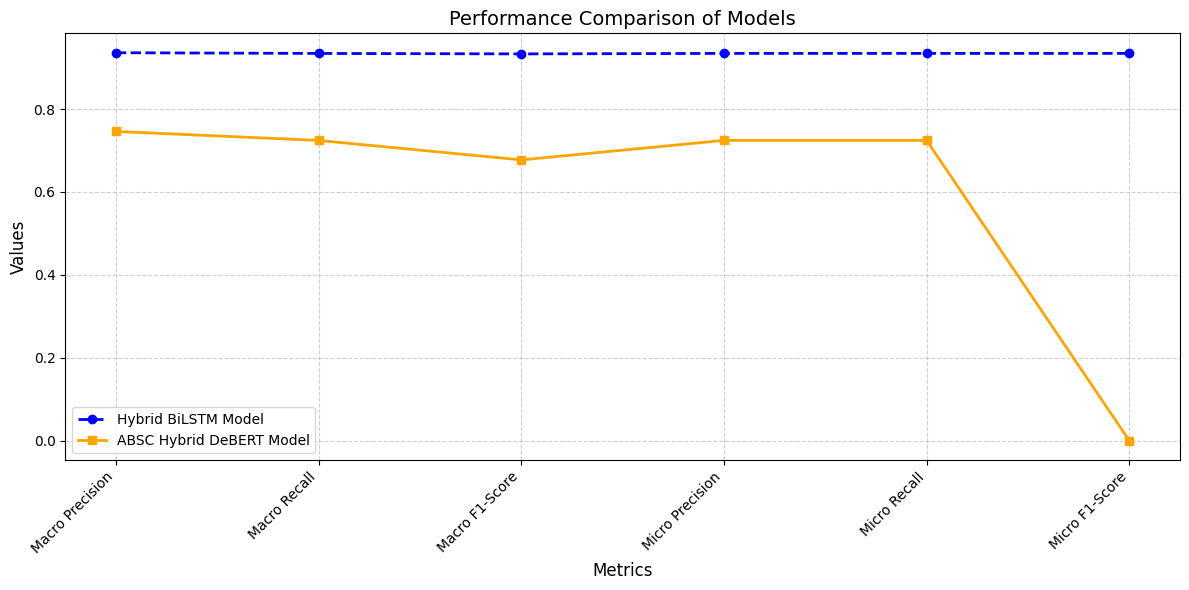

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Hybrid BiLSTM Model
bilstm_metrics = {
    "Macro Precision": 0.9358,
    "Macro Recall": 0.9341,
    "Macro F1-Score": 0.9330,
    "Micro Precision": 0.9342,
    "Micro Recall": 0.9342,
    "Micro F1-Score": 0.9342,
   }

# Data for ABSC Hybrid DeBERT Model
debert_metrics = {
    "Macro F1-Score": 0.6773,
    "Macro Precision": 0.7459,
    "Macro Recall": 0.7243,
    "Micro F1-score": 0.7243,
    "Micro Precision": 0.7243,
    "Micro Recall": 0.7243,
   }

# Metric names
metrics = list(bilstm_metrics.keys())

# Values for each model
bilstm_values = [bilstm_metrics[metric] for metric in metrics]
debert_values = [debert_metrics.get(metric, 0) for metric in metrics]

# Plotting
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x, bilstm_values, marker='o', label="Hybrid BiLSTM Model", color="blue", linestyle='--', linewidth=2)
ax.plot(x, debert_values, marker='s', label="ABSC Hybrid DeBERT Model", color="orange", linestyle='-', linewidth=2)

# Adding labels and title
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Values", fontsize=12)
ax.set_title("Performance Comparison of Models", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha="right", fontsize=10)
ax.legend()

# Adding grid for better readability
ax.grid(visible=True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()


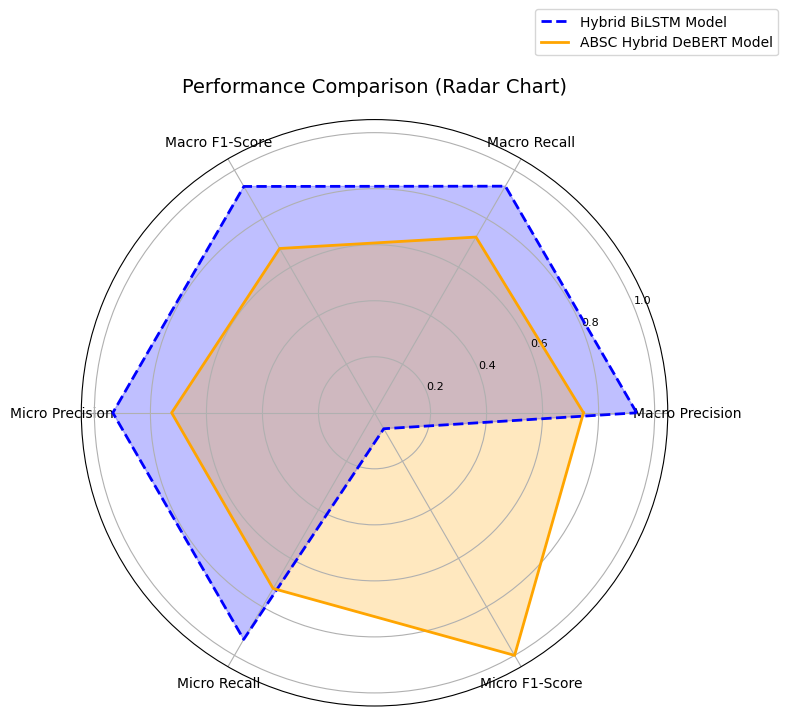

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Hybrid BiLSTM Model
bilstm_metrics = {
    "Macro Precision": 0.9358,
    "Macro Recall": 0.9341,
    "Macro F1-Score": 0.9330,
    "Micro Precision": 0.9342,
    "Micro Recall": 0.9342,
    "Micro F1-Score": 0.9342,
  }

# Data for ABSC Hybrid DeBERT Model
debert_metrics = {
    "Macro F1-Score": 0.6773,
    "Macro Precision": 0.7459,
    "Macro Recall": 0.7243,
    "Micro F1-score": 0.7243,
    "Micro Precision": 0.7243,
    "Micro Recall": 0.7243,
   }

# Metric names and values
metrics = list(bilstm_metrics.keys())
bilstm_values = [bilstm_metrics[metric] for metric in metrics]
debert_values = [debert_metrics.get(metric, 0) for metric in metrics]

# Normalize Hamming Loss to fit radar chart scaling (lower is better, so invert it)
bilstm_values[-1] = 1 - bilstm_values[-1]
debert_values[-1] = 1 - debert_values[-1]

# Create radar chart
num_metrics = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()

# Close the circle
bilstm_values += bilstm_values[:1]
debert_values += debert_values[:1]
angles += angles[:1]

# Plot radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, bilstm_values, label="Hybrid BiLSTM Model", color="blue", linewidth=2, linestyle='--')
ax.fill(angles, bilstm_values, color="blue", alpha=0.25)
ax.plot(angles, debert_values, label="ABSC Hybrid DeBERT Model", color="orange", linewidth=2, linestyle='-')
ax.fill(angles, debert_values, color="orange", alpha=0.25)

# Add metric labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=10)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=8)
ax.set_title("Performance Comparison (Radar Chart)", fontsize=14, pad=20)

# Add legend
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.2))

# Display plot
plt.tight_layout()
plt.show()


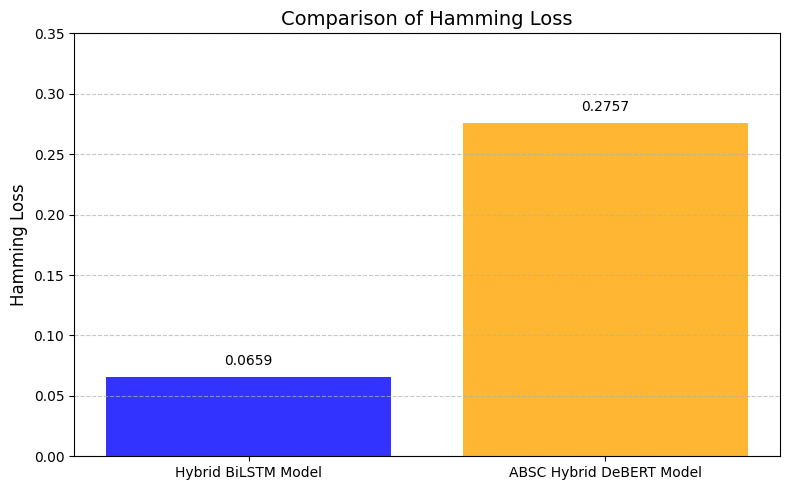

In [ ]:
import matplotlib.pyplot as plt

# Data for Hamming Loss
models = ["Hybrid BiLSTM Model", "ABSC Hybrid DeBERT Model"]
hamming_loss_values = [0.0659, 0.2757]

# Plotting Hamming Loss comparison
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(models, hamming_loss_values, color=["blue", "orange"], alpha=0.8)

# Adding value annotations
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.4f}", ha="center", fontsize=10)

# Adding labels and title
ax.set_ylabel("Hamming Loss", fontsize=12)
ax.set_title("Comparison of Hamming Loss", fontsize=14)
ax.set_ylim(0, 0.35)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
